<a href="https://colab.research.google.com/github/jery5237hent/Deep-Learning/blob/main/HW2_VAE_anime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(2021)
torch.cuda.manual_seed(2021)

In [ ]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    n_hidden_channel = 1024

    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = n_channel, out_channels=n_hidden_channel, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(n_hidden_channel),
        nn.ReLU(),
        # nn.MaxPool2d(n_hidden_channel),
        nn.Conv2d(in_channels = n_hidden_channel, out_channels=n_hidden_channel * 2, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(n_hidden_channel * 2),
        nn.ReLU(),
        nn.Flatten()
    )
    self.fc1 = nn.Linear(in_features = n_hidden_channel * 2 * 7 * 7, out_features=latent_dims)
    self.fc2 = nn.Linear(in_features = n_hidden_channel * 2 * 7 * 7, out_features=latent_dims)

    self.decoder = nn.Sequential(
        nn.Linear(in_features = latent_dims, out_features=n_hidden_channel * 2 * 7 * 7),
        nn.Unflatten(1, (n_hidden_channel * 2, 7, 7)),
        nn.ConvTranspose2d(in_channels = n_hidden_channel * 2, out_channels=n_hidden_channel, kernel_size=4, stride=2, padding=1),
        # nn.BatchNorm2d(n_hidden_channel),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels = n_hidden_channel, out_channels=n_channel , kernel_size=4, stride=2, padding=1),
        # nn.BatchNorm2d(n_channel),
        # nn.Sigmoid()
    )

  def latent(self, x):
    self.mu = self.fc1(x)
    self.ln_var = self.fc2(x)
    std = self.ln_var.mul(0.5).exp_()
    epsilon = torch.empty_like(std).normal_()

    return (epsilon.mul(std).add_(self.mu))

  def loss(self, beta, initial_img):
    loss = F.mse_loss(self.z.view(-1, WIDTH * HEIGHT), initial_img.view(-1, WIDTH * HEIGHT), reduction='sum')
    kl = -0.5 * torch.sum(1 + self.ln_var - self.mu.pow(2) - self.ln_var.exp())

    return beta * kl + loss
    
  def forward(self, x):
    dim = x.size(0)
    x = self.encoder(x)
    z = self.latent(x)
    z = self.decoder(z)
    self.z = z.view(dim, n_channel, WIDTH, HEIGHT)

    return self.z

  def interpolation(self, img1, img2):
    model.eval()
    interploation_lambda = np.linspace(0, 1, 11)
    fig, axs = plt.subplots(1, 11, figsize=(15, 12)) 
    img1, img2 = img1.float().unsqueeze(0).to(device), img2.float().unsqueeze(0).to(device)
    
    with torch.no_grad():
      for idx, l in enumerate(interploation_lambda):
        latent = model.encoder(img1)
        latent = model.fc1(latent)

        latent_1 = model.encoder(img2)
        latent_1 = model.fc1(latent_1)

        inter = l * latent + (1 - l) * latent_1
        inter_image = model.decoder(inter)
        inter_image = inter_image.cpu()

        plt.subplot(1, 11, idx + 1)
        plt.imshow(recover(inter_image[0]))
        plt.title('lambda = ' + str(round(l, 1)))
      plt.savefig('VAE_Q4_interpolation.png')
      plt.show() 

  def sample(self):
    model.eval()

    with torch.no_grad():

      latent = torch.randn(64, latent_dims, device=device)
      prediction = model.decoder(latent).cpu()
      prediction_grid = make_grid(prediction[:64], 8, 8).numpy()
      Image = np.transpose(prediction_grid, (1, 2, 0))
      Image = Image/np.amax(Image)
      Image = np.clip(Image, 0, 1)

      plt.figure(figsize=(10, 8))
      plt.imshow(Image)
      plt.title('Sample from prior:')
      plt.savefig('VAE_Q2_sample.png')
      plt.show()

In [ ]:
# !unzip data.zip

In [ ]:
from PIL import Image
import glob
WIDTH = HEIGHT = 28

images = []
for filename in glob.glob('./data/*.png'): 
    im = Image.open(filename).resize((WIDTH, HEIGHT))
    images.append(np.array(im)/255)
images = np.array(images)
images = np.transpose(images, (0, 3, 1, 2))
images.shape

(21551, 3, 28, 28)

In [ ]:
X = torch.from_numpy(images)
DATA = TensorDataset(X)
n_batch = 64

In [ ]:
train, test = random_split(DATA, [int(0.8*len(DATA)), len(DATA) - int(0.8*len(DATA))], generator = torch.Generator().manual_seed(42))
train_loader = DataLoader(train, batch_size = n_batch, shuffle=True)
test_loader = DataLoader(test, batch_size = n_batch, shuffle=True)

In [ ]:
latent_dims = 2
n_epochs = 30
lr = 1e-4
n_channel = 3

In [ ]:
def VAE_train(beta):
  model = VAE().to(device)
  optimizer = optim.AdamW(params = model.parameters(), lr = lr, weight_decay=1e-4)
  model.train()
  loss = []

  for epoch in range(n_epochs):
    epoch_loss = 0
    n = 0
    for batch_img in train_loader:
        optimizer.zero_grad()
        batch_img[0] = batch_img[0].float().to(device)
        prediction = model(batch_img[0])

        batch_loss = model.loss(beta, batch_img[0])

        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()
        n += batch_img[0].shape[0]
    epoch_loss /= n
    loss.append(epoch_loss)
    print(f'Epoch: {epoch+1} / {n_epochs}, loss: {epoch_loss}')
  return model, loss

In [ ]:
import matplotlib.pyplot as plt

beta = 1
model, loss = VAE_train(beta)
fig = plt.figure()
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('beta = 1')
plt.savefig('Learning_curve_Q1.png')
plt.show()

Epoch: 1 / 30, loss: 556.4375408694805
Epoch: 2 / 30, loss: 100.12352833050863


In [ ]:
def VAE_test(beta):
  model.eval()

  test_loss = 0
  n = 0
  for batch_img in test_loader:
      with torch.no_grad():
          batch_img = batch_img[0].float().to(device)
          prediction = model(batch_img)
          loss = model.loss(beta, batch_img)

          test_loss += loss.item()
          n += batch_img.shape[0]
  test_loss /= n
  # test_losses.append(epoch_loss)
  print(f'loss: {test_loss}' )

VAE_test(beta)

loss: 96.94262644343685


1. Implement VAE and show the learning curve and some reconstructed samples like the given examples. (10%)

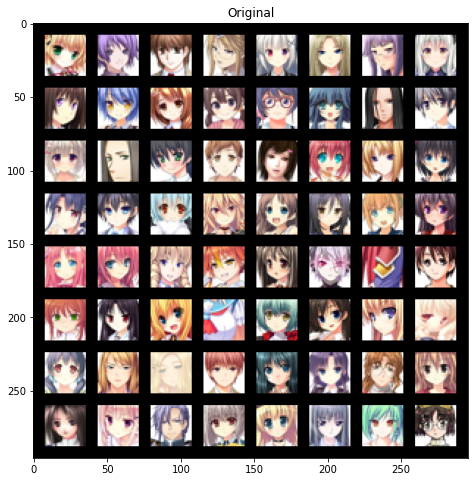

In [ ]:
from torchvision.utils import make_grid

img = iter(test_loader).next()
original = make_grid(img[0][:64], 8, 8).numpy()

plt.figure(figsize=(10, 8))
plt.imshow(np.transpose(original, (1, 2, 0)))
plt.title('Original')
plt.savefig('VAE_Q1_Original.png')
plt.show()

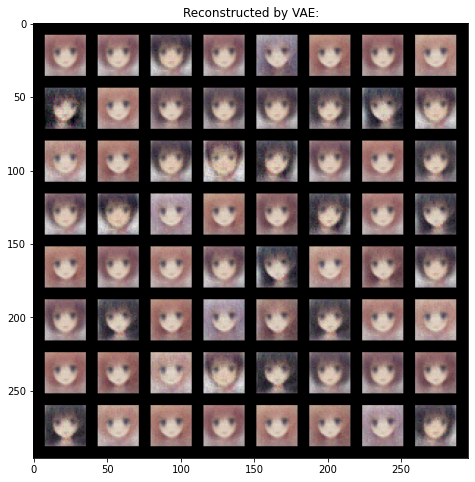

In [ ]:
with torch.no_grad():
  img[0] = img[0].float().to(device)
  prediction = model(img[0]).cpu()
  prediction_grid = make_grid(prediction[:64], 8, 8).numpy()
  Image = np.transpose(prediction_grid, (1, 2, 0))
  Image = Image/np.amax(Image)
  Image = np.clip(Image, 0, 1)

  plt.figure(figsize=(10, 8))
  plt.imshow(Image)
  plt.title('Reconstructed by VAE:')
  plt.savefig('VAE_Q1_Reconstructed.png')
  plt.show()

2. Sample the prior p(z) and use the latent codes z to synthesize some examples when your model is well-trained. (5%)

In [ ]:
# def sample():
#   model.eval()

#   with torch.no_grad():
#     std = model.ln_var.mul(0.5).exp_()
#     latent = torch.randn(24, latent_dims, device=device) * std + model.mu
#     prediction = model.decoder(latent).cpu()
#     prediction_grid = make_grid(prediction[:64], 8, 8).numpy()
#     Image = np.transpose(prediction_grid, (1, 2, 0))
#     Image = Image/np.amax(Image)
#     Image = np.clip(Image, 0, 1)

#     plt.figure(figsize=(10, 8))
#     plt.imshow(Image)
#     plt.title('Sample from prior:')
#     plt.show()

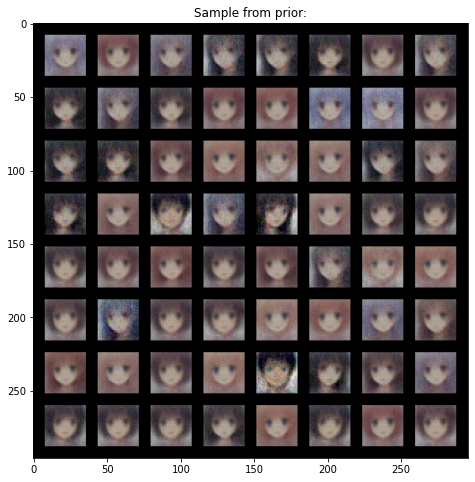

In [ ]:
model.sample()

3. Show the synthesized images based on the interpolation of two latent codes z between two real samples. (5%)

In [ ]:
def recover(img):
  img = img.numpy()
  Image = np.transpose(img, (1, 2, 0))
  Image = Image/np.amax(Image)
  Image = np.clip(Image, 0, 1)

  return Image

In [ ]:
# def interpolation(img1, img2):
#   model.eval()
#   interploation_lambda = np.linspace(0, 1, 10)
#   fig, axs = plt.subplots(2, 5, figsize=(15, 6)) 
#   img1, img2 = img1.float().unsqueeze(0).to(device), img2.float().unsqueeze(0).to(device)
  
#   with torch.no_grad():
#     for idx, l in enumerate(interploation_lambda):
#       latent = model.encoder(img1)
#       latent = model.fc1(latent)

#       latent_1 = model.encoder(img2)
#       latent_1 = model.fc1(latent_1)

#       inter = l * latent + (1 - l) * latent_1
#       inter_image = model.decoder(inter)
#       inter_image = inter_image.cpu()

#       plt.subplot(2, 5, idx + 1)
#       plt.imshow(recover(inter_image[0]))
#       plt.title('lambda = ' + str(round(l, 1)))
#     plt.show() 

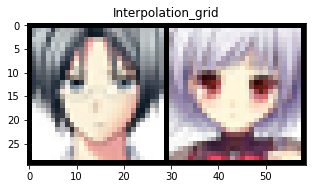

In [ ]:
img = iter(test_loader).next()
interpolation_grid = make_grid(img[0][:2], 2, 1)
# Image = np.transpose(interpolation_grid, (1, 2, 0))
# Image = Image/np.amax(Image)
# Image = np.clip(Image, 0, 1)
Image = recover(interpolation_grid)
plt.figure(figsize=(5, 4))
plt.imshow(Image)
plt.title('Interpolation_grid')
plt.savefig('VAE_Q4_Interpolation_selected.png')
plt.show()

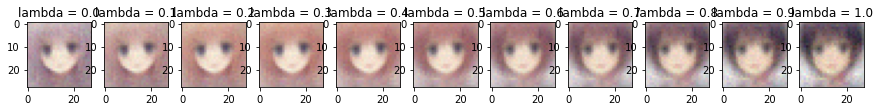

In [ ]:
img1, img2 = img[0][0], img[0][1]
model.interpolation(img1, img2)

4. Multiply the Kullback-Leiblier (KL) term with a scale λ and tune λ (e.g. λ = 0 and λ = 100) then show the results based on steps 1, 2, 3 and some analyses. (10%)

$\beta$ = 0

In [ ]:
beta = 0
model, loss = VAE_train(beta)
fig = plt.figure()
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('beta = 0')
plt.savefig('Learning_curve_Q4_beta0.png')
plt.show()

In [ ]:
with torch.no_grad():
  img[0] = img[0].float().to(device)
  prediction = model(img[0]).cpu()
  prediction_grid = make_grid(prediction[:64], 8, 8).numpy()
  Image = np.transpose(prediction_grid, (1, 2, 0))
  Image = Image/np.amax(Image)
  Image = np.clip(Image, 0, 1)

  plt.figure(figsize=(10, 8))
  plt.imshow(Image)
  plt.title('Reconstructed by VAE:')
  plt.savefig('VAE_Q1_Reconstructed_beta0.png')
  plt.show()

In [ ]:
model.sample()

In [ ]:
model.interpolation(img1, img2)

$\beta$ = 100

In [ ]:
beta = 100
model, loss = VAE_train(beta)
fig = plt.figure()
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('beta = 100')
plt.savefig('Learning_curve_Q4_beta100.png')
plt.show()

In [ ]:
with torch.no_grad():
  img[0] = img[0].float().to(device)
  prediction = model(img[0]).cpu()
  prediction_grid = make_grid(prediction[:64], 8, 8).numpy()
  Image = np.transpose(prediction_grid, (1, 2, 0))
  Image = Image/np.amax(Image)
  Image = np.clip(Image, 0, 1)

  plt.figure(figsize=(10, 8))
  plt.imshow(Image)
  plt.title('Reconstructed by VAE:')
  plt.savefig('VAE_Q1_Reconstructed_beta100.png')
  plt.show()

In [ ]:
model.sample()

In [ ]:
model.interpolation(img1, img2)